# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

# Lab Class #2 - Learning Signals

In this practice, we are going to verify many of the concepts studied in the class "Learning Signals". If you need to recall the theory, check the video below.

In [1]:
#@title
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/OcxvX4bMnzk', width='560', height='315')

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import imageio

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Grayscale
from torchvision.transforms.functional import to_tensor, to_pil_image
from collections import OrderedDict
import numpy as np
import skimage
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.fft import fft, fftfreq
from typing import Sequence, Tuple, Union
from ipywidgets import interactive
from IPython.display import display
import ipywidgets as widgets
import time

import seaborn as sns

In [3]:
torch.manual_seed(777)
sns.set_theme()

# 1 Sampling and Reconstruction

We are going to start working with 1D signals in the interval $[-1, 1]$. Shannon theorem states some conditions for reconstruction of bandlimited signals after uniform sampling. Let's verify it in practice.

In [4]:
def get_mgrid(sidelen, dim=2, start=-1, end=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(start, end, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class Signal1D(Dataset):
    def __init__(self, coords, values):
        super().__init__()
        self.values = values.view(-1, 1)
        self.coords = coords

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.values

def sinusoidal(nsamples, freqs, biases=None):
    coords = get_mgrid(nsamples, 1).view(-1)
    values = torch.zeros(nsamples)
    if biases is None:
      biases = torch.zeros(len(freqs))
    for freq, bias in zip(freqs, biases):
      values = values + torch.sin(freq * coords + bias)
    return Signal1D(coords, values)

def plot_signals(signals:Union[Signal1D, Sequence[Signal1D]]):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    lines = ['-', '--', '-.', ':']
    fig, ax = plt.subplots(figsize=(16, 8))
    if not isinstance(signals, Sequence):
      signals = [signals]
    for i, signal in enumerate(signals):
        ax.plot(signal.coords, 
                signal.values, 
                label=f'S{i}', color=COLORS[i%len(COLORS)])
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

## 1.1 Uniform Sampling

Let's take some samples of continuous functions uniformly over the interval $[-1, 1]$ an plot them. To make it easier to see we are working with bandlimited signals, we are going to start with combinations of sinusoidal functions, so we know the exact the frequency content of the signal.

In [5]:
def plot_samples1D(func, nsamples):
    x = get_mgrid(nsamples, 1)
    samples = func(x)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(x, samples, 'o', label=f'Uniform samples')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

def multi_plot(dots, curves=[], labels=[]):
    linewidth = 1
    fig, ax = plt.subplots(figsize=(14, 7))
    if dots:
      ax.plot(*dots, 'o', label=f'Uniform samples')
    for i, (x, y) in enumerate(curves):
        if i > 0:
          linewidth = 3
        ax.plot(x, y, label=labels[i], linewidth = linewidth)

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

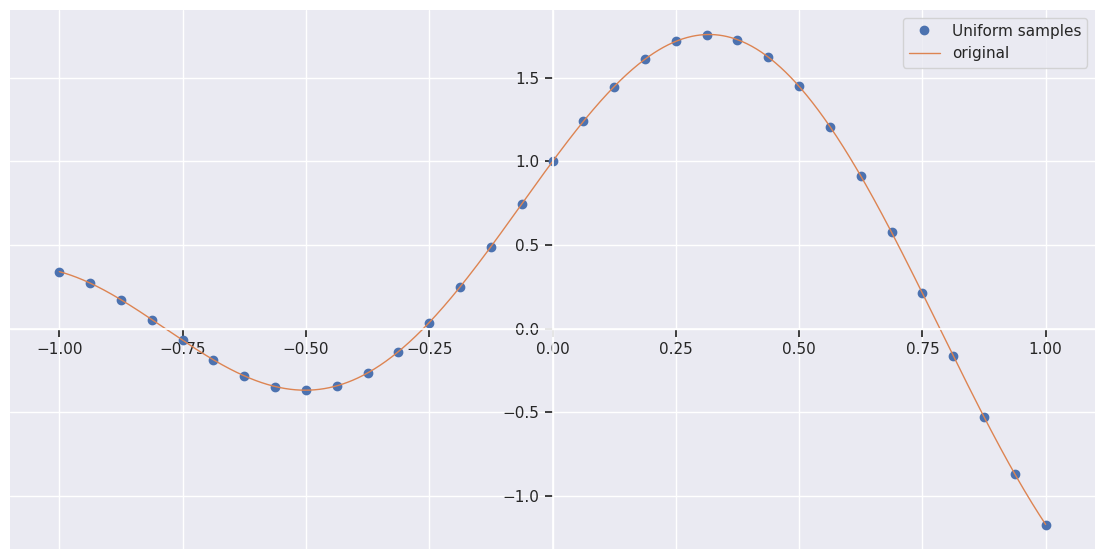

In [6]:
gridres = 1025
nsamples = 33
signal = lambda x: (np.cos(2 * x) + np.sin(4 * x))
full_grid = get_mgrid(gridres, 1)
samples_grid = get_mgrid(nsamples, 1)

multi_plot((samples_grid, signal(samples_grid)), 
           [(full_grid, signal(full_grid))], 
           ['original'])

## 1.2 Reconstruction

* Implement a function to reconstruct a signal sampled uniformly using the Shanon basis, that is the function $sinc(x) = \frac{sin(x)}{x}$. Plot the original signal and the reconstructed signal (sample more points) in the same graph. Did it work? Why?

* Reduce the sampling rate until it's below the Nyquist limit. What happens when you try to reconstruct the signal? Alternatively, you may add higher frequencies to the signal.

* Try again with a signal composed of more frequencies.

In [7]:
# Suggested template
def shannon_reconstruction(x, y):
    # compute what you need
    sinc = lambda x: (torch.sin( torch.pi * x) / ( torch.pi * x)) # my implementation 
                                                                  #but pytorch deals with division by zero
    n_samples = x.size(0)
    f_s = 1/(x[1] - x[0]) #sampling frequency
    print("The sampling rate is " + str(f_s.item()))
    def rec(t):
        n_grid = t.size(0)
        a = torch.kron(torch.ones(1 , n_samples),t).transpose(0,1)
        b = torch.kron(x, torch.ones(1, n_grid))
        return torch.mm(y.transpose(0,1) , torch.sinc(f_s * (a - b))).transpose(0,1)
    # return a function that given a coordinate t, 
    # computes the reconstructed value
    return rec

The sampling rate is 16.0


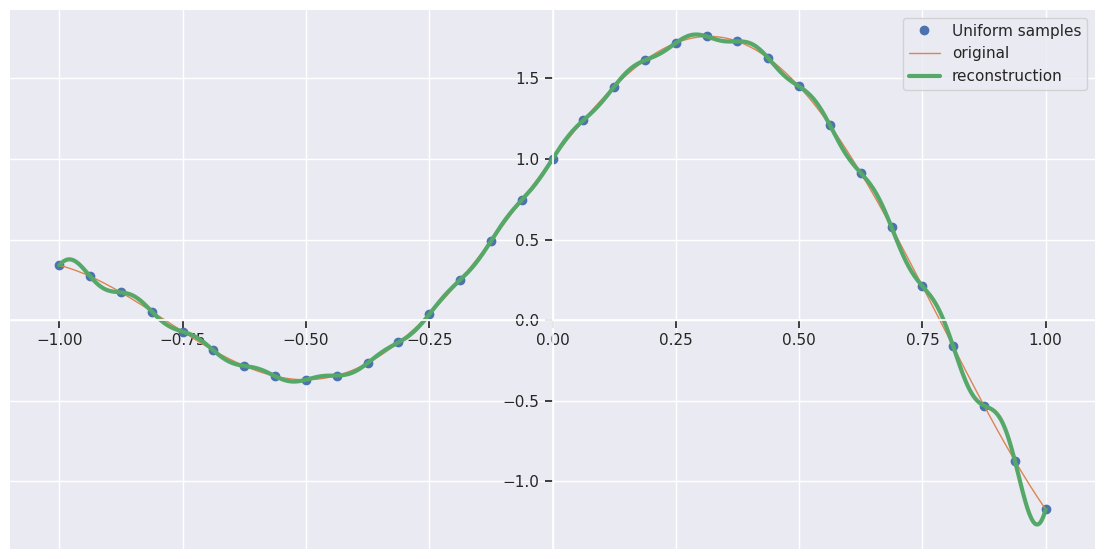

In [8]:
# write your answer here
rec_signal = shannon_reconstruction(samples_grid,signal(samples_grid))

multi_plot((samples_grid, signal(samples_grid)), 
           [(full_grid, signal(full_grid)), (full_grid, rec_signal(full_grid))], 
           ['original' , 'reconstruction'])

a) Funcionou (desconsiderando os efeitos de borda). Ao representar um sinal na forma discreta estamos fazendo duas operações no domínio do tempo. A primeira é uma multiplicação por uma função $comb(t) = \sum_{n=-\infty}^{n=\infty} \delta(t-n\Delta t)$ responsável pela amostragem e a segunda é uma multiplicação pela função $rect(t)$ responsável pelo truncamento do sinal (uma vez que um sinal infinito não é representável). A primeira operação implica uma convolução no domínio da frequencia com a transformada de Fourier da função $comb(t)$ (que também é uma $comb$ com período $1/\Delta t$). Essa convolução vai causar uma repetição do espectro do sinal $x(t)$ (ver imagem [1]). Para recuperar o sinal novamente devemos multiplicar o espectro de $x(t)$ por uma função $rect(\omega$) o que implica em uma convolução no domínio do tempo por uma $sinc(t)$. Note que a multiplicação pela $rect(\omega)$ só não adicionará novas frenquências à $x(t)$ se não houver um overlapping de frequências. Isso implica nas duas seguintes condições:
1.  O espectro de $x(t)$ deve ser limitado;
2.  A frequência de amostragem $1/\Delta t$ da função $comb(t)$ deve ser maior que $2W$ onde $W$ é a maior frequência de $x(t)$ para garantir que não há overlapping;

Note que essas duas condições foram atendidas nesse caso uma vez que $x(t)$ tem $W = 4 rad/s$ e a frequência de amostragem é igual a $16 > 2W$.

Por fim, a segunda operação que é feita no sinal (multiplicação por uma função $rect$) para o seu truncamento não é tratada o que implica no efeito de borda.


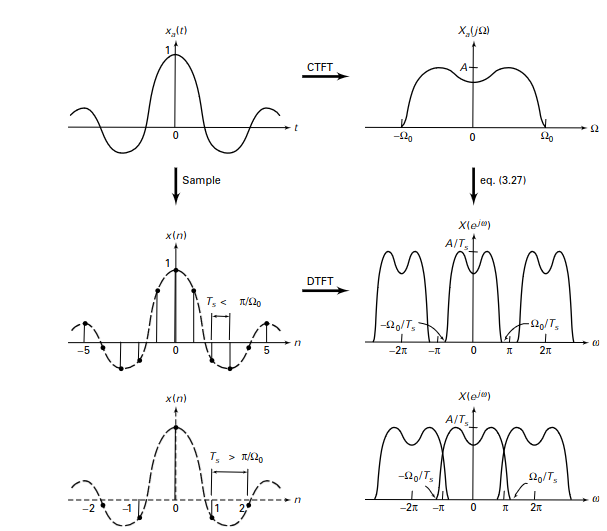

The sampling rate is 2.0


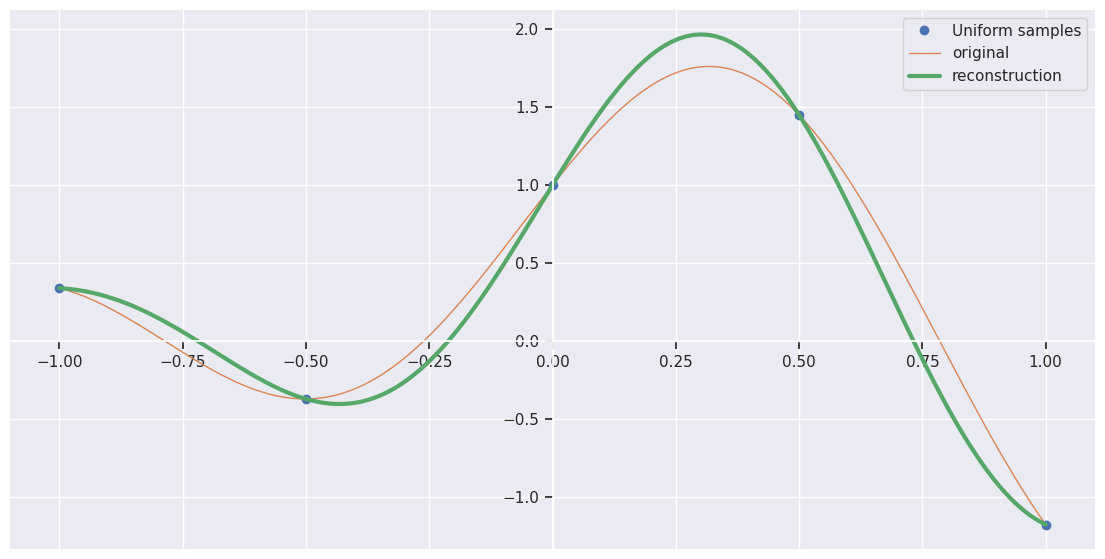

In [9]:
n_samples_2 = 5
samples_grid_2 = get_mgrid(n_samples_2, 1)

rec_signal_nyquist = shannon_reconstruction(samples_grid_2,signal(samples_grid_2))

multi_plot((samples_grid_2, signal(samples_grid_2)), 
           [(full_grid, signal(full_grid)), (full_grid, rec_signal_nyquist(full_grid))], 
           ['original' , 'reconstruction'])

b) Quando reduzimos a frequência de amostragem para $2 < 8$ é notado que o sinal reconstruído representa uma nova função, configurando o fenômeno de *aliasing*, isto é, uma ambiguidade na representação.

The sampling rate is 81.00004577636719
The sampling rate is 9.999998092651367


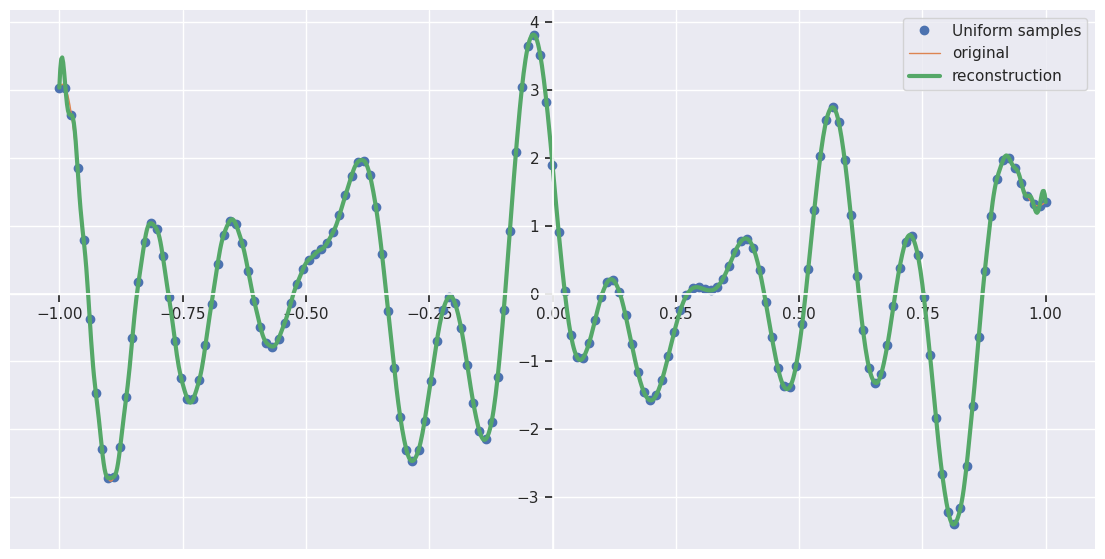

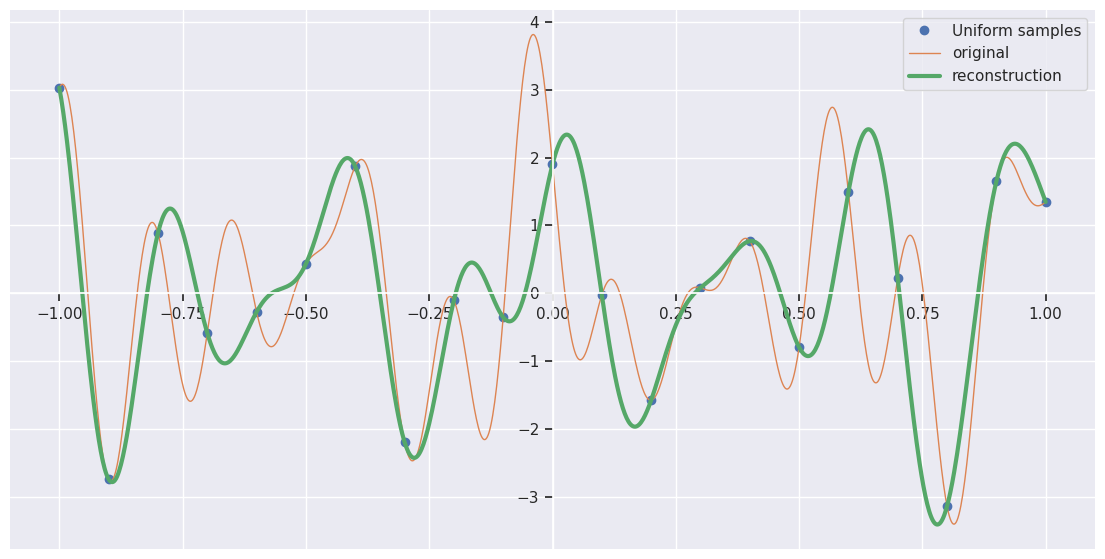

In [10]:
signal_multiples = lambda x: np.cos(25*x/2) + np.cos(np.pi/4 + 37*x/2) + np.cos(65*x/2 + np.pi/3) + np.cos(81*x/2 + 3*np.pi/5)

n_samples_2 = 163
samples_grid_2 = get_mgrid(n_samples_2, 1)

rec_signal_multiples = shannon_reconstruction(samples_grid_2,signal_multiples(samples_grid_2))

multi_plot((samples_grid_2, signal_multiples(samples_grid_2)), 
           [(full_grid, signal_multiples(full_grid)), (full_grid, rec_signal_multiples(full_grid))], 
           ['original' , 'reconstruction'])

n_samples_2 = 21
samples_grid_2 = get_mgrid(n_samples_2, 1)

rec_signal_multiples_nyquist = shannon_reconstruction(samples_grid_2,signal_multiples(samples_grid_2))

multi_plot((samples_grid_2, signal_multiples(samples_grid_2)), 
           [(full_grid, signal_multiples(full_grid)), (full_grid, rec_signal_multiples_nyquist(full_grid))], 
           ['original' , 'reconstruction'])

c) Nese caso, pode ser observado que a reconstrução abaixo do limite Nyquist representou um sinal com menores frequências.

## 1.3 Fourier Transform

The code below allows you to plot the Fast Fourier Transform of a signal, and check its representation in the frequency domain.

In [11]:
def plot_fft1D(signals, color_order = None, x_lim = None):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    if not color_order:
      color_order = [0,1,2,3,4]
    lines = ['-', '--', '-.', ':']
    if not isinstance(signals, Sequence):
      signals = [signals]
    fig, ax = plt.subplots(figsize=(16, 8))
    for i, signal in enumerate(signals):
        W = signal.values.view(-1).cpu().detach().numpy()
        N = len(W)
        yf = fft(W)
        xf = fftfreq(N, 2/N)[:N//2]
        ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]),
                label=f'S{i}', color=COLORS[color_order[i]%len(COLORS)])
    if (x_lim):
      plt.xlim([0,x_lim])
    plt.legend()

*   Based on the experiments you did on the previous section, use the FFT algorithm to compare the frequencies present in the original signal and its reconstruction. Check it when you have a sampling rate above the Nyquist limit, and also when it's below this limit. Do you see anything interesting?

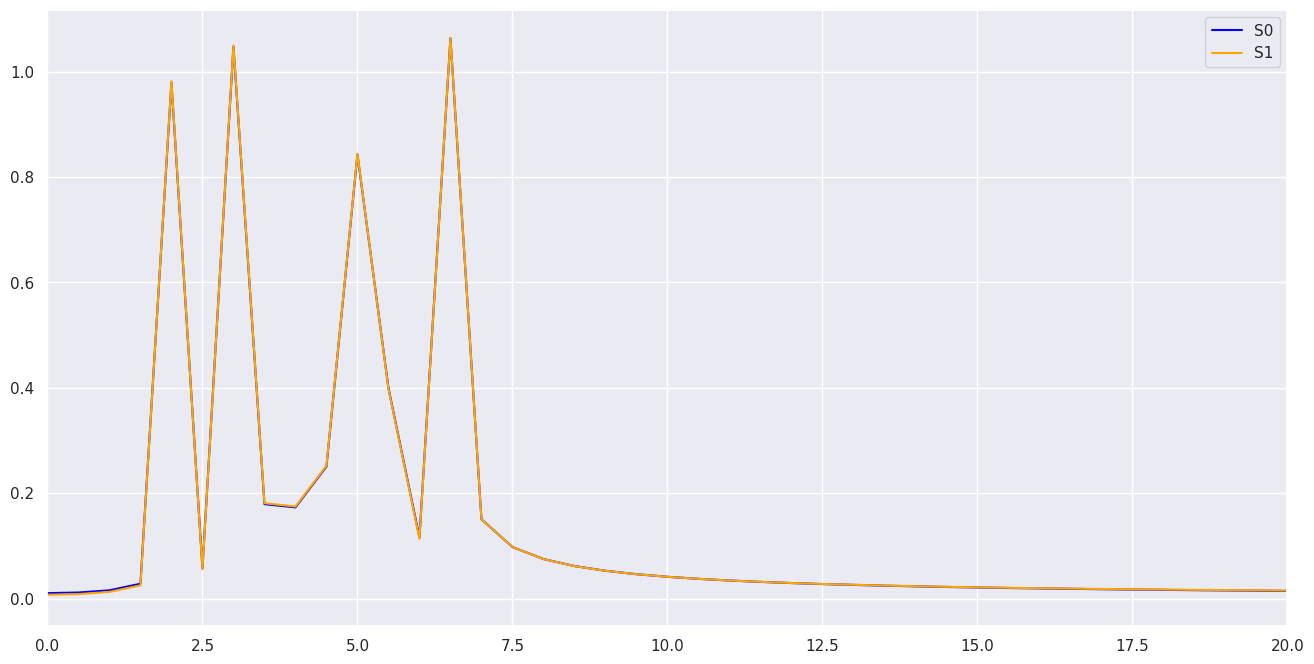

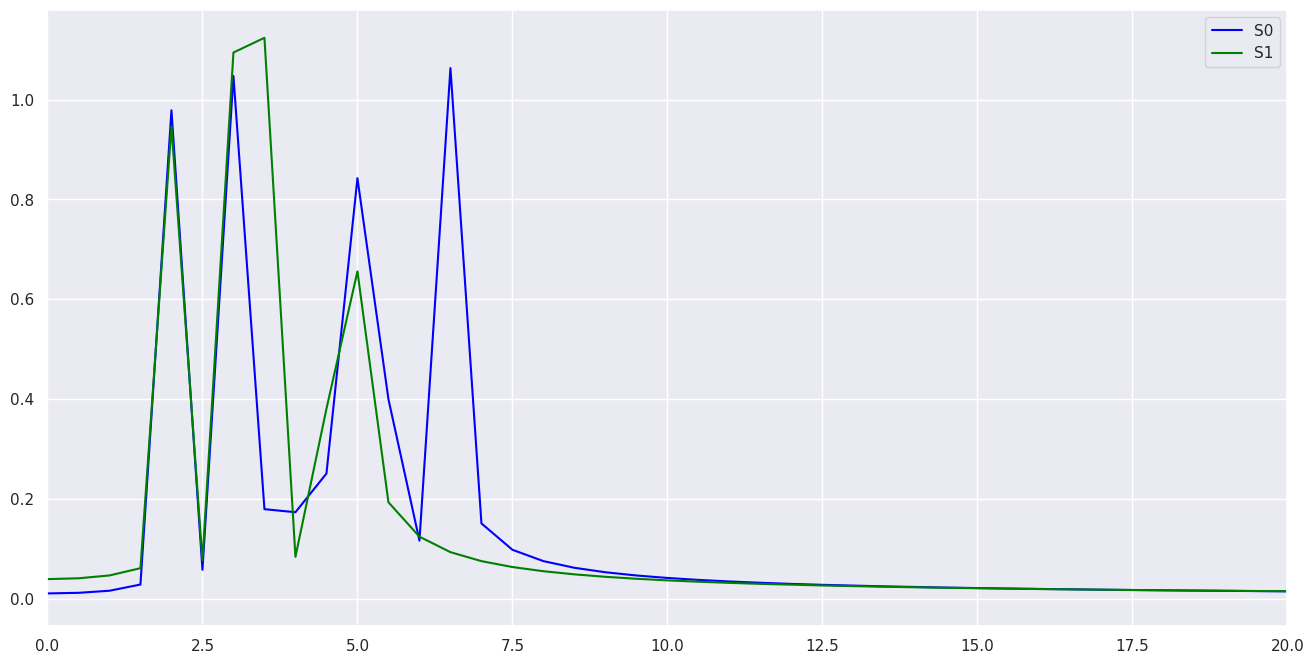

In [12]:
# write your answer here
ori_signal_obj = Signal1D(full_grid, signal_multiples(full_grid))
rec_signal_obj = Signal1D(full_grid, rec_signal_multiples(full_grid))
rec_signal_nyquist_obj = Signal1D(full_grid, rec_signal_multiples_nyquist(full_grid))
plot_fft1D([ori_signal_obj, rec_signal_obj], x_lim=20)
plot_fft1D([ori_signal_obj, rec_signal_nyquist_obj],[0,2], x_lim=20)

Primeiramente, nota-se a presença de ruído no espectro de ambos os sinais. Isso ocorre devido à convolução do espectro real com a função $sinc$ no momento do seu truncamento. Ademais, nota-se no espectro reconstruído abaixo da frequência de Nyquist (verde) frequências mais baixas que a real. Esse é um exemplo do fenômeno de *alisaing* em que o sinal reconstruído representa um *alias* do sinal verdadeiro. 

# 2 Aliasing

We saw that Aliasing is an effect that causes higher frequencies to be interpreted as lower frequencies under certain conditions. We are going to check how aliasing artifacts look like when we are working with 1D and 2D signals.

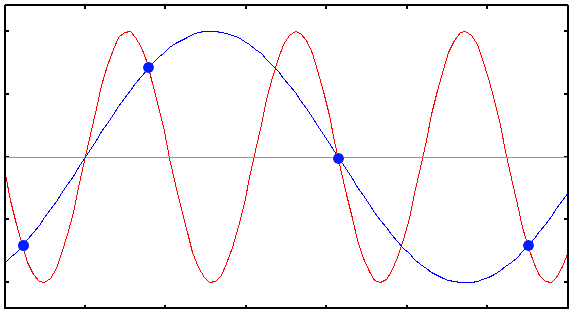

## 2.1 Spoting aliasing artifacts

Perlin Noise is a kind of stochastic signal with large applications in procedural modeling in computer graphics. We are going to use it to generate more sophisticated signals for the next exercise.

In [13]:
def blend(x):
  return 6*x**5 - 15*x**4 + 10*x**3

def noise(scale, samples):
    # create a list of 2d vectors
    angles = torch.rand(scale) * 2*torch.pi
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)

    x = torch.linspace(0, scale-1, samples)
    noise_values = []
    for value in x[:-1]:
        i = torch.floor(value).long()
        lower, upper = gradients[i], gradients[i+1]

        dot1 = torch.dot(lower, torch.tensor([value - i, 0]))
        dot2 = torch.dot(upper, torch.tensor([value - i - 1, 0]))
        # TODO: review interpolation
        k1 = blend(value-i)
        k2 = blend(i+1 - value)
        interpolated = k1*dot2 + k2*dot1 
        noise_values.append(interpolated.item())
    
    noise_values.append(0.0)
    return torch.tensor(noise_values)

def perlin_noise(nsamples, scale=10, octaves=1, p=1):
    print(p)
    pnoise = 0
    for i in range(octaves):
        partial = noise(2**i * scale, nsamples)/(p**i)
        pnoise = partial + pnoise
    return Signal1D(get_mgrid(nsamples, 1), pnoise)

* Generate some Perlin Noise signals exploring different setting of its parameters. When you have an idea of how it works, choose one that presents fine details. Plot the signal and its FFT. Analyze what you see.

Observa-se que ao se iterar o parâmetro `octaves` é somado um sinal com menor amplitude e maior frequência. O parâmetro `scale` é responsável por aumentar a frequência e o parâmetro `p` por reduzir a amplitude. Conclui-se que a presença de detalhes finos é proporcional ao número de  `octaves`.

In [14]:
# write your answer here
def show_perlin(scale, octaves, p):
  perlin_high_obj = perlin_noise(gridres, scale, octaves, p)
  multi_plot([], 
           [ (full_grid , perlin_high_obj.values)], 
           ['original'])
  plot_fft1D([perlin_high_obj], x_lim = 20)
  plt.show()

w = interactive(show_perlin, scale=widgets.IntSlider(min=5, max=40, step=2, value=10),
                octaves=widgets.IntSlider(min=1, max=10, step=2, value=1),
                p = widgets.IntSlider(min=0, max=40, step=2, value=0))
display(w)


interactive(children=(IntSlider(value=10, description='scale', max=40, min=5, step=2), IntSlider(value=1, desc…

* Create a new Perlin Noise signal from your previously generated signal by naively subsampling it: just keep 1 sample for every *sumbsampling_factor* samples and ignore the others.
* Use the sinc basis to reconstruct the noise signal and compare the original signal to the reconstructed signal. Can you spot any alising artifacts? If so, describe them.
* Check the FFT plot for both the original noise signal and the reconstructed noise signal.

Observa-se que o padrão de alta frequência obtido pelas oitavas não foi recuperado. Isso é uma consequência do fenômeno de aliasing uma vez que , ao se observar o espectro, as frequências altas foram substitúidas por frequências menores. 

2
The sampling rate is 20.479999542236328


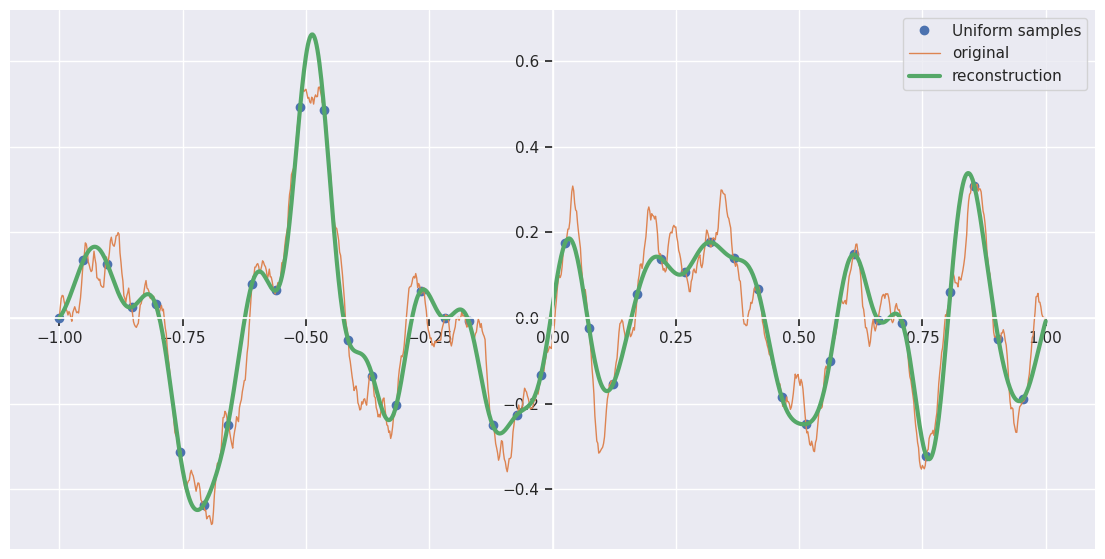

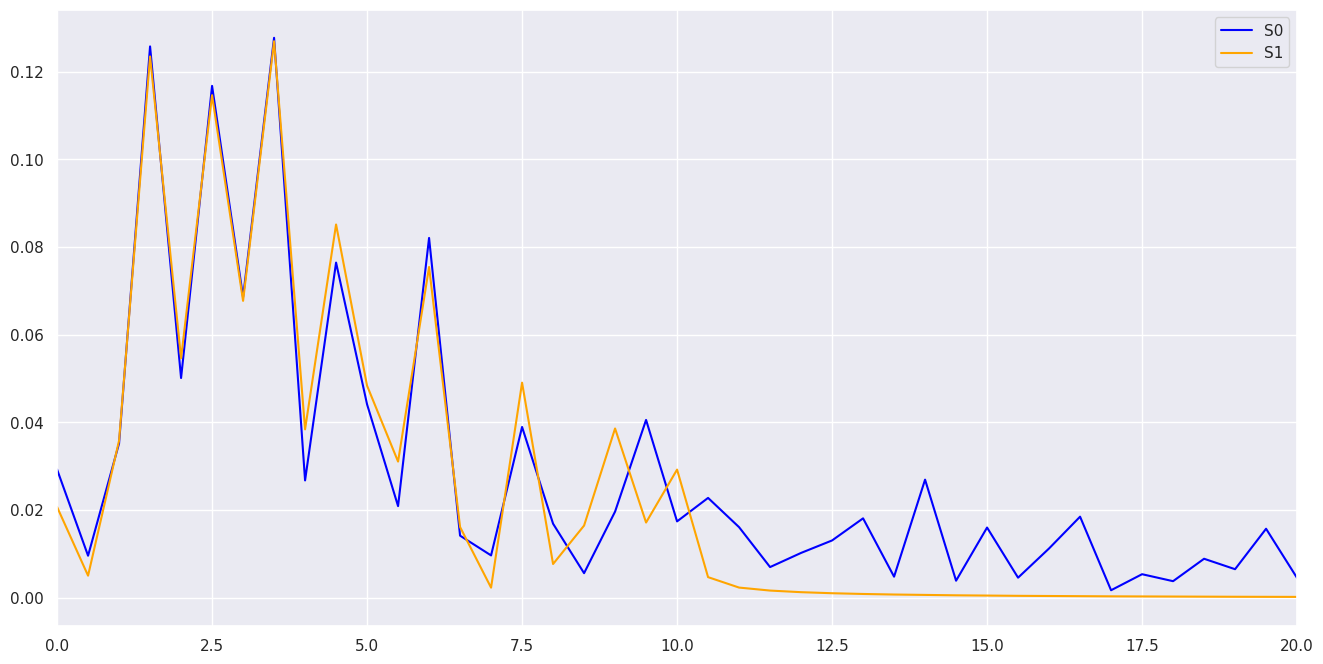

In [15]:
# write your answer here
perlin_high_obj = perlin_noise(gridres, 11, 9, 2)

subsampling_factor = 25 # 5, 25, 41, 205
perlin_sub = perlin_high_obj.values[range(0,gridres,subsampling_factor)]
samples_perlin = full_grid[range(0,gridres,subsampling_factor)]

rec_perlin = shannon_reconstruction(samples_perlin, perlin_sub)
rec_perlin_obj = Signal1D(full_grid, rec_perlin(full_grid))
multi_plot([samples_perlin, perlin_sub], 
           [ (full_grid , perlin_high_obj.values), (full_grid, rec_perlin_obj.values)], 
           ['original','reconstruction'])

#fft
plot_fft1D([perlin_high_obj, rec_perlin_obj], x_lim=20)

## 2.2 Aliasing Artifacts in Images

Download the image of a striped t-shirt using the code below, then load and display the image.

In [16]:
# download image
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg

--2023-04-17 13:47:05--  https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255515 (250K) [image/jpeg]
Saving to: ‘camisa.jpg’

camisa.jpg          100%[===================>] 249.53K  --.-KB/s    in 0.03s   

2023-04-17 13:47:05 (8.24 MB/s) - ‘camisa.jpg’ saved [255515/255515]



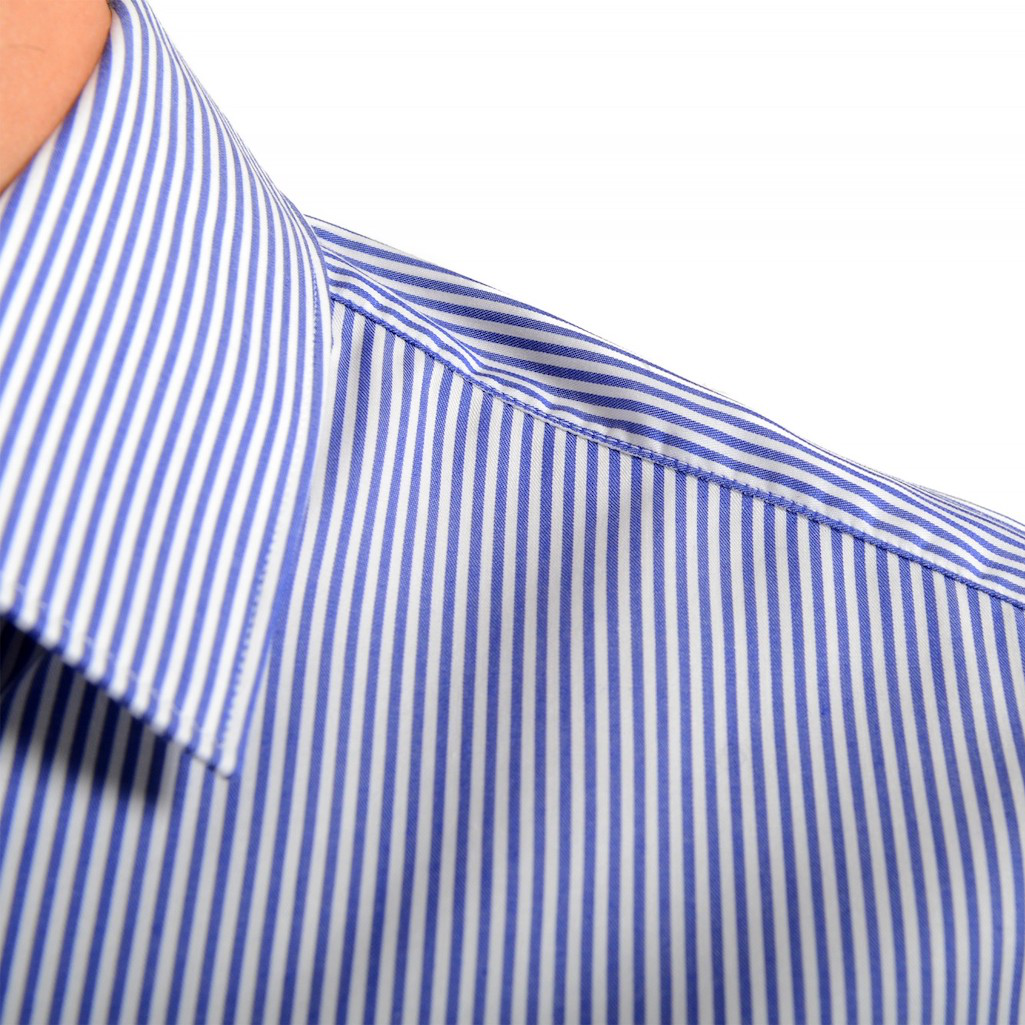

In [17]:
tshirt = Image.open('/content/camisa.jpg')
tshirt

* Convert the image to a tensor or numpy array representation and naively subsample it by a factor of 8. After checking the result, can you see any alising artifacts? Explain.

* Try a higher subsampling factor. Does it display more artifacts?

If you prefer, you can resize the image to a bigger size using the following snippet:

```python
# img is a numpy array that contains the pixels values
# dim is the new size; e.g. 513
Image.fromarray(img).resize((dim, dim), Image.BICUBIC)
```

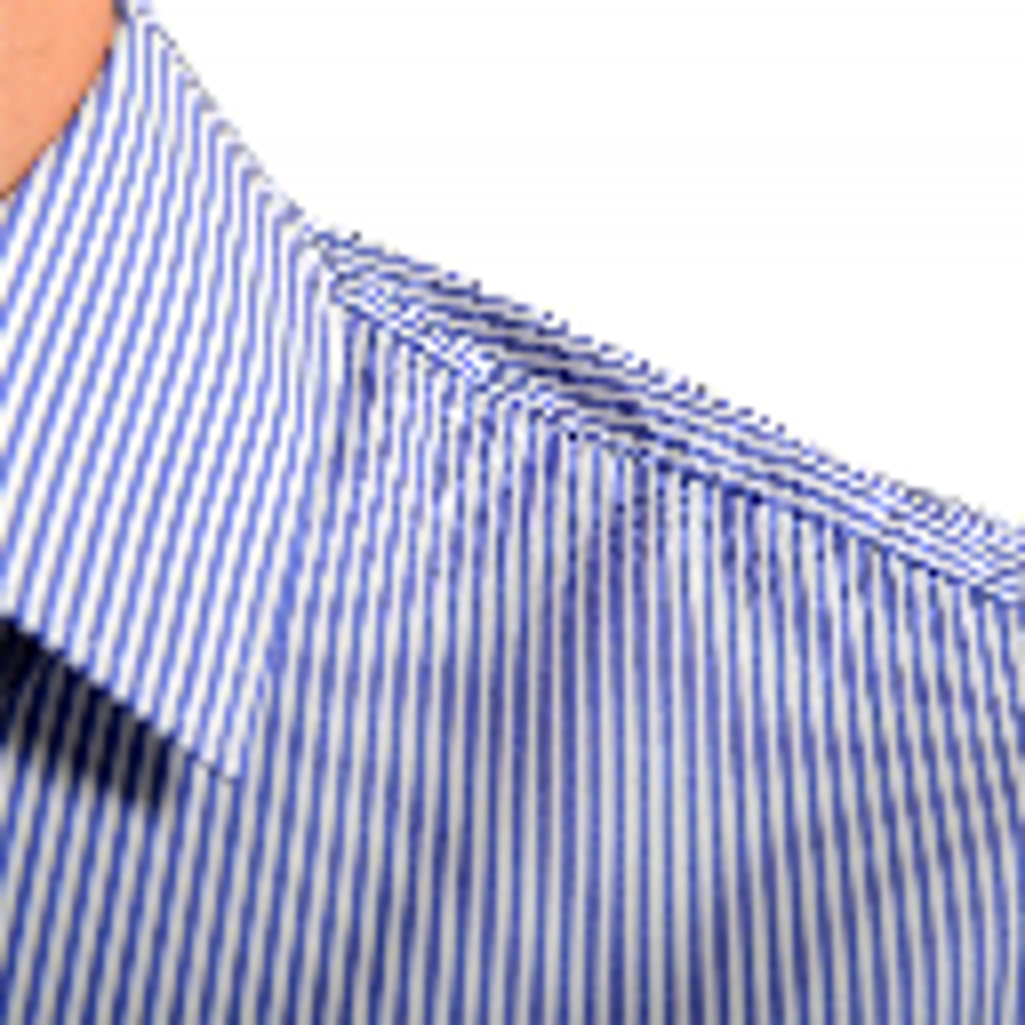

In [18]:
# write your answer here
sampling_factor = 8

tshirt_np = np.array(tshirt)
tshirt_torch = torch.from_numpy(tshirt_np)
tshirt_size = tshirt_torch.size()

new_size_x = tshirt_size[0]//sampling_factor 
new_size_y = tshirt_size[1]//sampling_factor 

mask_x = torch.zeros(1,tshirt_size[0], dtype=torch.bool)
mask_y = torch.zeros(tshirt_size[1],1, dtype=torch.bool)

mask_x[0,0:-1:sampling_factor] = True
mask_y[0:-1:sampling_factor,0] = True

mask = torch.kron(mask_x,mask_y)
sampled_img = tshirt_torch[mask,:].reshape((-1,new_size_y,3))

Image.fromarray(sampled_img.numpy()).resize((tshirt_size[0], tshirt_size[1]), Image.BICUBIC)

Para explicar o que ocorreu, considere a seguir um sinal extraído do meio da camisa, bem como sua subamsotragem reconstruída. Note que a subamostragem não foi capaz de representar as altas freqûencias do sinal original. Asim, temos um sinal de baixa frequência "imitando" um sinal de alta frequência, caracterizando o "aliasing". Esse mesmo efeito ocorreu com o perlin noise.

The sampling rate is 63.500030517578125


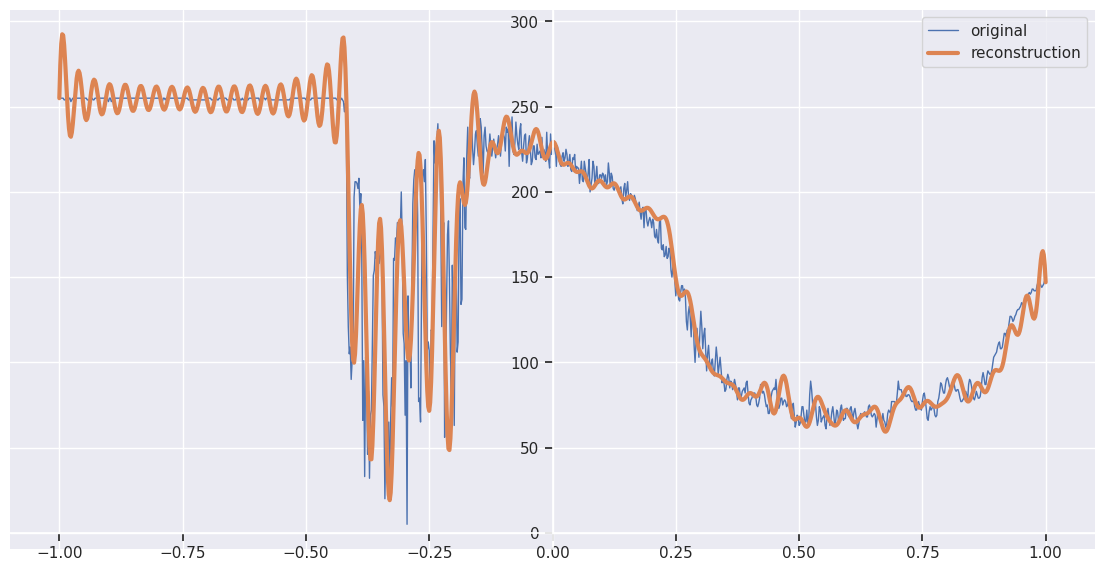

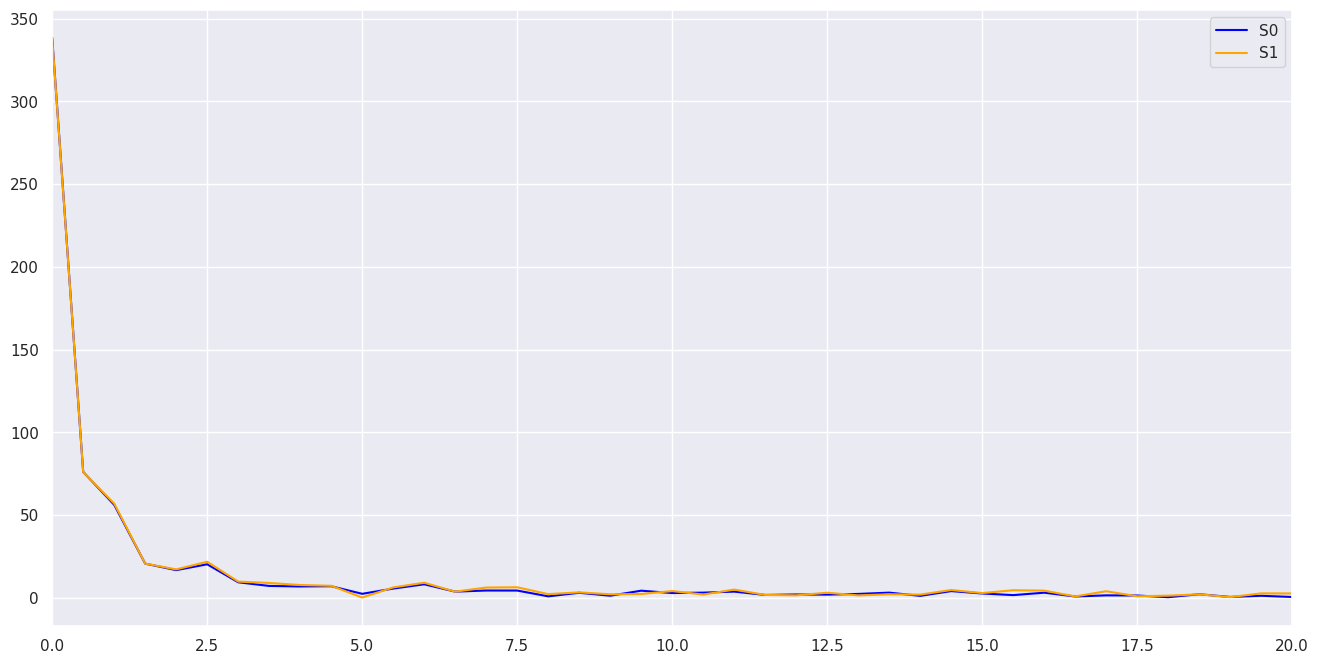

In [19]:
id_prev = tshirt_size[1]//2
id_curr = new_size_y//2

signal_prev = tshirt_torch[:, id_prev, 0].reshape((tshirt_size[1],1)).float()
signal_sub_sampling = sampled_img[:, id_curr, 0].reshape((new_size_y,1)).float()

new_samples_grid = get_mgrid(new_size_y, 1)
rec_signal = shannon_reconstruction(new_samples_grid, signal_sub_sampling)

multi_plot([], 
           [ (full_grid, signal_prev), (full_grid, rec_signal(full_grid))], 
           ['original','reconstruction'])
signal_prev_obj = Signal1D(full_grid, signal_prev)
rec_signal_obj = Signal1D(full_grid, rec_signal(full_grid))
plot_fft1D([signal_prev_obj, rec_signal_obj], x_lim=20)

# 3 Fitting an 2D signal (image) using a neural network

In the previous assignment, you learned how to train a neural network to fit a 1D function using the basic components in the PyTorch framework. Now, we are going to solve a similar problem, but in 2D.



In [20]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.0]), torch.Tensor([1.0]))
    ])
    img = transform(img)
    return img

class ImageSignal(Dataset):
    def __init__(self, sidelength, path=None, gray_scale=True):
        super().__init__()
        if path is None:
          img = get_cameraman_tensor(sidelength)
          self.pixels = img.permute(1, 2, 0).view(-1, 1)
        else:
          if gray_scale:
            img = Image.open(path).convert('L').resize((sidelength, sidelength))
            img = to_tensor(img)
            self.pixels = img.permute(1, 2, 0).view(-1, 1)
          else:
            img = Image.open(path).resize((sidelength, sidelength))
            img = to_tensor(img)
            self.pixels = img.permute(1, 2, 0).view(-1, 3)
        self.coords = get_mgrid(sidelength, 2)
        self.dim = sidelength

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

class ReLuNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def forward(self, coords):
        output = self.layers(coords)
        return output

def plot_tensor_img(output, dim, return_img=False, gray_scale=True):
    img = output.cpu().view(dim, dim, -1).detach().numpy()
    if return_img:
        return img
    plt.grid(False)
    if gray_scale:
      plt.imshow(img, cmap='gray')
    else:
      plt.imshow(img)
def train(model, dataloader, epochs, device, steps_til_summary=100, gif_path=""):
    model.to(device)
    model.train()
    optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)
    
    dim = int(np.sqrt(ground_truth.size(0)))
    if gif_path:
        writer = imageio.get_writer(gif_path, mode='I', duration=0.3)

    for step in range(epochs):
        model_output = model(model_input)    
        loss = ((model_output - ground_truth)**2).mean()

        if not (step % steps_til_summary):
            print("Step %d, Total loss %0.6f" % (step, loss))
            #plot_tensor_img(model_output, dim)

        if gif_path and (step % 10 == 0):
            img = np.clip(model_output.cpu().view(dim, dim,-1).detach().numpy(), 0, 1) 
            writer.append_data(np.uint8(img * 255))

        optim.zero_grad()
        loss.backward()
        optim.step()
    # last inference
    model.eval()
    model_output = model(model_input)
    plot_tensor_img(model_output, dim)
    img = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
    writer.append_data(np.uint8(img * 255))
    writer.close()

## 3.1 Training a regular MLP using ReLu as activation function

* Train a model using the ReLuNetwork provided in code cell above. Try to fit at least 2 images. What do you observe in the result?

* **[Optional]** Can you do better? Experiment different activation functions and/or a different set of hyperparameters and try to improve the result. Feel free to change the network architecture.



Inicialmente, foram feitas modificações no código acima para que o dado de entrada também possa ser uma imagem RGB. A primeira imagem testada foi a camisada listrada da questão anterior. Ficou claro nesse exemplo que o padrão de alta frequência das listras não foi representado. De forma geral, a imagem resultante é composta primariamente por linhas (característica das camadas escondidas) e mudanças bruscas na fronteiras dessas linhas. Isso ocorre, uma vez que é dificil recuperar detalhes de alta frequência apenas somando funções clipadas no zero.

In [21]:
#download rgb image
!wget https://raw.githubusercontent.com/Hilton-Marques/3d_computer_graphics_impa/main/assignment_2/my_cats.jpeg

--2023-04-17 13:47:08--  https://raw.githubusercontent.com/Hilton-Marques/3d_computer_graphics_impa/main/assignment_2/my_cats.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60476 (59K) [image/jpeg]
Saving to: ‘my_cats.jpeg’

my_cats.jpeg        100%[===================>]  59.06K  --.-KB/s    in 0.02s   

2023-04-17 13:47:08 (3.67 MB/s) - ‘my_cats.jpeg’ saved [60476/60476]



Step 0, Total loss 0.621920
Step 100, Total loss 0.030752
Step 200, Total loss 0.027588
Step 300, Total loss 0.025913
Step 400, Total loss 0.024682
Step 500, Total loss 0.023560
Step 600, Total loss 0.022520
Step 700, Total loss 0.021537
Step 800, Total loss 0.020670
Step 900, Total loss 0.019907
Step 1000, Total loss 0.019318
Step 1100, Total loss 0.018899
Step 1200, Total loss 0.018633
Step 1300, Total loss 0.018449
Step 1400, Total loss 0.018318
Step 1500, Total loss 0.018213
Step 1600, Total loss 0.018142
Step 1700, Total loss 0.018064
Step 1800, Total loss 0.018004
Step 1900, Total loss 0.017953


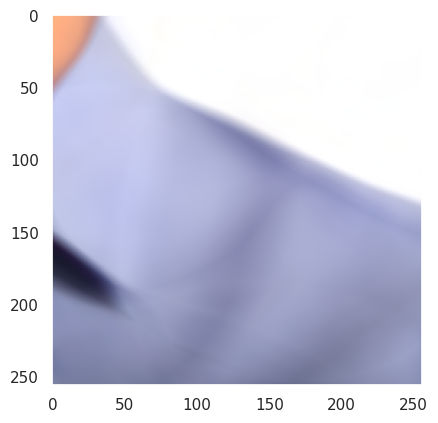

In [22]:
# write your answer here
#RGBimage
example_rgb = ImageSignal(256, gray_scale=False, path="/content/camisa.jpg")
model_rgb = ReLuNetwork()
train(model_rgb, example_rgb, 2000, "cuda",gif_path="/content/stripped_shirt.gif")


Step 0, Total loss 0.306425
Step 100, Total loss 0.018614
Step 200, Total loss 0.017283
Step 300, Total loss 0.015970
Step 400, Total loss 0.014048
Step 500, Total loss 0.011670
Step 600, Total loss 0.009505
Step 700, Total loss 0.007836
Step 800, Total loss 0.006765
Step 900, Total loss 0.006159
Step 1000, Total loss 0.005696
Step 1100, Total loss 0.005361
Step 1200, Total loss 0.005081
Step 1300, Total loss 0.004838
Step 1400, Total loss 0.004630
Step 1500, Total loss 0.004451
Step 1600, Total loss 0.004339
Step 1700, Total loss 0.004173
Step 1800, Total loss 0.004050
Step 1900, Total loss 0.003945


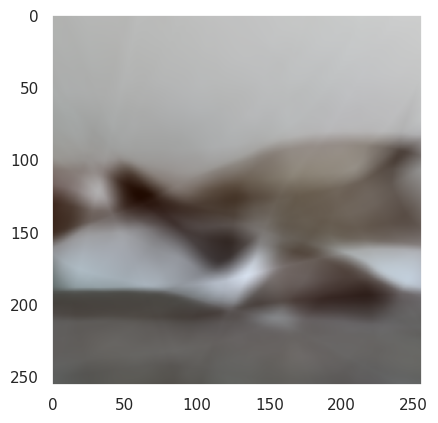

In [23]:
#RGBimage
example_rgb = ImageSignal(256, gray_scale=False, path="/content/my_cats.jpeg")
model_rgb = ReLuNetwork()
train(model_rgb, example_rgb, 2000, "cuda",gif_path="/content/my_cats.gif")

Step 0, Total loss 0.302191
Step 100, Total loss 0.037858
Step 200, Total loss 0.023427
Step 300, Total loss 0.018922
Step 400, Total loss 0.015929
Step 500, Total loss 0.013652
Step 600, Total loss 0.011710
Step 700, Total loss 0.010118
Step 800, Total loss 0.009128
Step 900, Total loss 0.008238
Step 1000, Total loss 0.007702
Step 1100, Total loss 0.007280
Step 1200, Total loss 0.007008
Step 1300, Total loss 0.006730
Step 1400, Total loss 0.006530
Step 1500, Total loss 0.006370
Step 1600, Total loss 0.006278
Step 1700, Total loss 0.006149
Step 1800, Total loss 0.005990
Step 1900, Total loss 0.005891


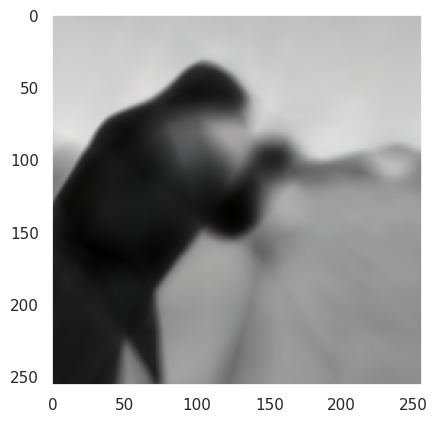

In [24]:
#Gray scale image
example_gray = ImageSignal(256)
model_gray = ReLuNetwork()
train(model_gray, example_gray, 2000, "cuda",gif_path="/content/camera_man.gif")

Uma primeira modificação foi permitir que a rede possa representar em um maior intervalo $[-∞,+∞]$ e através de uma camada sigmoid fazer um mapeamento para $[0,1]$. É observado um resultado ligeiramente melhor.

Step 0, Total loss 0.038685
Step 100, Total loss 0.016257
Step 200, Total loss 0.015131
Step 300, Total loss 0.012484
Step 400, Total loss 0.009318
Step 500, Total loss 0.007160
Step 600, Total loss 0.006154
Step 700, Total loss 0.005630
Step 800, Total loss 0.005257
Step 900, Total loss 0.004959
Step 1000, Total loss 0.004706
Step 1100, Total loss 0.004499
Step 1200, Total loss 0.004306
Step 1300, Total loss 0.004141
Step 1400, Total loss 0.003992
Step 1500, Total loss 0.003862
Step 1600, Total loss 0.003745
Step 1700, Total loss 0.003653
Step 1800, Total loss 0.003551
Step 1900, Total loss 0.003463


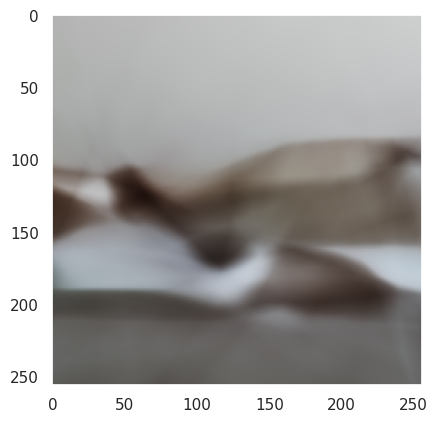

In [25]:
class ReLuNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Sigmoid(),
        )

    def forward(self, coords):
        output = self.layers(coords)
        return output
model = ReLuNetwork()
train(model, example_rgb, 2000, "cuda",gif_path="/content/teste.gif")

## 3.2 Fourier Transform of Images

In [26]:
def plot_fft2D(pixels, dim, gray_scale=True):
    pixels_trans = pixels.view(dim, dim, -1).squeeze(-1)
    fourier_tensor = torch.fft.fftshift(
                    torch.fft.fft2(pixels_trans))
    magnitude = 20 * np.log(abs(fourier_tensor.numpy()) + 1e-10)
    mmin = np.min(magnitude)
    magnitude = (magnitude - mmin) / (np.max(magnitude) - mmin)
    img = np.uint8(magnitude * 255)
    plt.grid(False)
    plt.imshow(img, cmap='gray')

The code above computes the Fast Fourier Transform of a 2D image and displays the magnitude of the FFT as another image. The lower frequencies will appear near the center of the image while the higher frequencies will appear near the border of the image. The magnitude is normalized for better visualization.

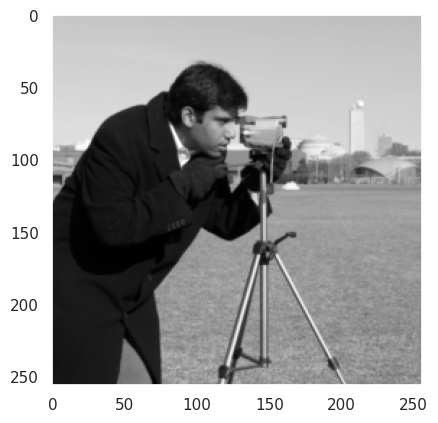

In [27]:
example = ImageSignal(256)
plot_tensor_img(example.pixels, example.dim)

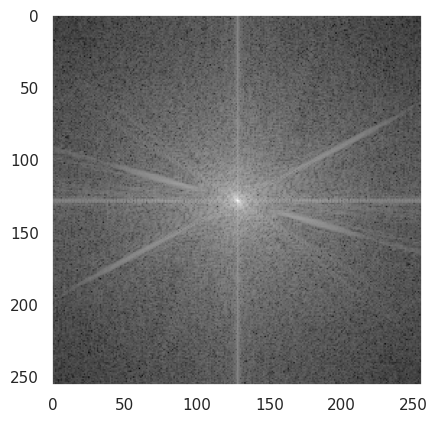

In [28]:
plot_fft2D(example.pixels, example.dim)

* Visualize the FFT of the result image of the trained model. How does it compare to the ground truth?

É observado uma baixa densidade na zona de alta frequência do espectro. No entanto, parece que as baixas frequências foram bem representadas.

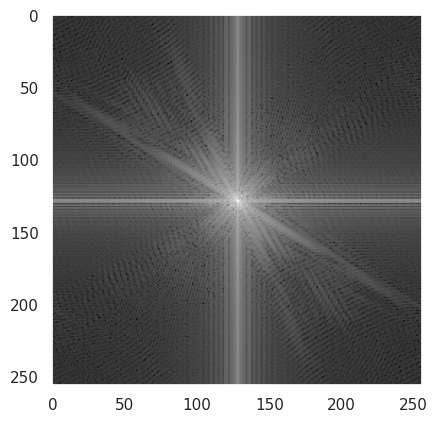

In [29]:
# write your answer here
sidelength = 256
coords = get_mgrid(sidelength, 2)
coords.to("cpu")
model_gray.to("cpu")
model_gray.eval()
with torch.no_grad():
    model_output = model_gray(coords)
plot_fft2D(model_output[:,0], sidelength)

## 3.3 Training a Sinusoidal Neural Network to fit an image

In [30]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

The code above defines a simplified version of a SIREN* (sinusoidal representation network. This kind of network uses sines as the activation function. 

Notice that it's not as trivial as changing $relu()$ for $sin()$, as it requires a special initialization to guarantee stability and convergence during training. You can find the paper and the original [code in this link](https://www.vincentsitzmann.com/siren/), and check the details.

* Train a Siren network to fit the same images you were working with. Is the result better? Explain.

* Use the FFT to analyze the frequencies learned by the network. Why do you think 

Sim, a rede melhorou consideravelmente. Observa-se que, já na época 100 a Siren já obtém um erro menor que a última época das redes anteriores. Além disso, é observado no espectro maiores detalhes de alta frequência. 

Step 0, Total loss 0.300515
Step 100, Total loss 0.001453
Step 200, Total loss 0.001109
Step 300, Total loss 0.000924
Step 400, Total loss 0.000805
Step 500, Total loss 0.000720
Step 600, Total loss 0.000652
Step 700, Total loss 0.000590
Step 800, Total loss 0.000535
Step 900, Total loss 0.000485


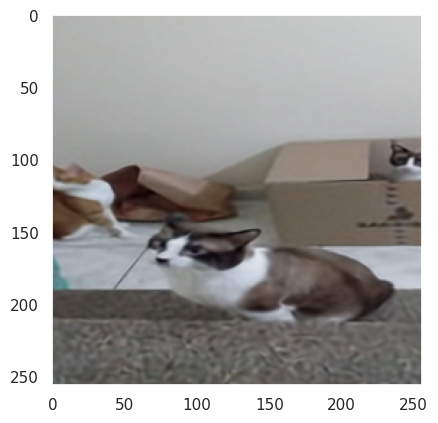

In [31]:
# write your answer here
model_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
train(model_siren, example_rgb, 1000, "cuda",gif_path="/content/teste.gif")

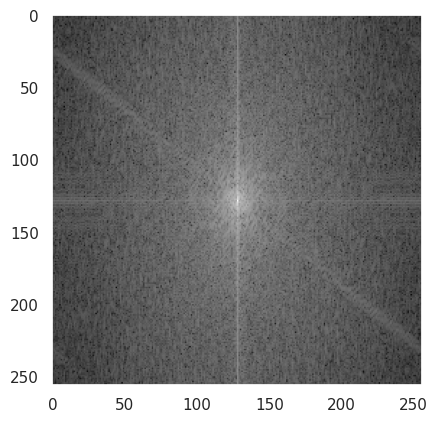

In [32]:
#Reference fft
#change to gray scale
pixels_trans = example_rgb.pixels.view(sidelength, sidelength, -1).squeeze(-1).permute(2, 0, 1)
transform = Grayscale()
pixels_trans = transform(pixels_trans).permute(1, 2, 0)
#Apply fft
plot_fft2D(pixels_trans, sidelength)

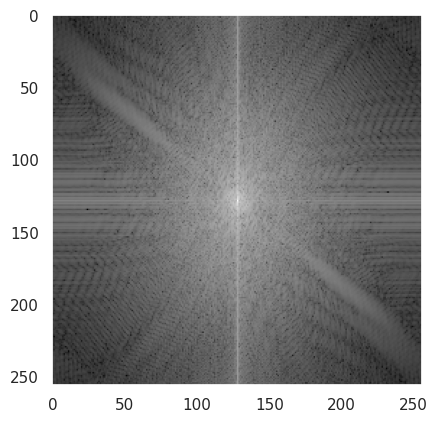

In [33]:
# Eval fft
sidelength = 256
coords = get_mgrid(sidelength, 2)
coords.to("cpu")
model_siren.to("cpu")
model_siren.eval()
with torch.no_grad():
    siren_output = model_siren(coords)

#change to gray scale
pixels_trans = siren_output.view(sidelength, sidelength, -1).squeeze(-1).permute(2, 0, 1)
transform = Grayscale()
pixels_trans = transform(pixels_trans).permute(1, 2, 0)
#Apply fft
plot_fft2D(pixels_trans, sidelength)